# Data Descriptive Analysis

This analysis serves to provide a global descriptive analysis of the effects of the Ukraine-Russia conflict on the price, supply and supplier composition of the import of wheat, sunflower oil and maize to the Netherlands. As a supplement to the paper


## Trade Data [EUROSTAT]
International trade in goods statistics (ITGS) published by Eurostat measure the value and quantity of goods traded between the EU Member States and their trade partners. The data that we've gathered for you contain the import of three goods:
- Sunflower oil
- Maize corn
- Wheat

The data contains among others, the following four fields for the case:

- TIME_PERIOD: the month in which the goods were imported
- declarant: The country to where the goods are imported (3 = The Netherlands)
- partner: The country where the goods originate from.
- indicators: Indicates whether the value is the Quantity or the Value measure
- OBS_Value: the field that indicates the actual value.

### You can find the product codes here:

https://ec.europa.eu/eurostat/ramon/nomenclatures/index.cfm?TargetUrl=LST_NOM_DTL&StrNom=CN_2022&StrLanguageCode=EN&IntPcKey=&StrLayoutCode=HIERARCHIC&IntCurrentPage=1

Query for sunflower oil:

https://ec.europa.eu/eurostat/ramon/nomenclatures/index.cfm?TargetUrl=LST_NOM_DTL&StrNom=CN_2022&StrLanguageCode=EN&IntPcKey=49230475&StrLayoutCode=HIERARCHIC

#### View of the data:

Select product name from the following: 
- WHEAT
- SUNFLOWER OIL
- MAIZE

In [15]:
import pandas as pd
import datetime as dt
import datetime
from datetime import date
from dateutil.relativedelta import relativedelta

from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

product_name = 'MAIZE'

if product_name == 'SUNFLOWER OIL':
    trade_data = pd.read_csv("Data/sunflower_oil.csv")

if product_name == 'MAIZE':
    trade_data = pd.read_csv("Data/maize_corn.csv")
    
if product_name == 'WHEAT':
    trade_data = pd.read_csv("Data/wheat.csv")

plt.style.use('ggplot')

colors = plt.cm.Spectral(np.linspace(0,1,30))
plt.rcParams["figure.figsize"] = (20,3)

trade_data["TIME_PERIOD"] = pd.to_datetime(trade_data["TIME_PERIOD"], format = '%Y-%m').dt.date
trade_data = trade_data.rename(columns={"partner": "PARTNER_codes", "declarant": "DECLARANT_codes"})
# trade_data = trade_data.drop_duplicates()
# trade_data = trade_data.dropna()

Add data of countries (Spain and Germany) for generalizability assessment

In [16]:
if product_name == 'SUNFLOWER OIL':
    trade_data_sim = pd.read_csv("Data/sunflower_oil_similar_countries_new.csv")

if product_name == 'MAIZE':
    trade_data_sim = pd.read_csv("Data/maize_corn_similar_countries_new.csv")
    
if product_name == 'WHEAT':
    trade_data_sim = pd.read_csv("Data/wheat_similar_countries.csv")

trade_data_sim["TIME_PERIOD"] = pd.to_datetime(trade_data_sim["TIME_PERIOD"], format = '%Y-%m').dt.date
trade_data_sim = trade_data_sim.rename(columns={"partner": "PARTNER_codes", "declarant": "DECLARANT_codes"})
trade_data_sim = trade_data_sim.drop_duplicates()

germany_data = trade_data_sim.loc[(trade_data_sim['DECLARANT_codes'] == 4)]
denmark_data = trade_data_sim.loc[(trade_data_sim['DECLARANT_codes'] == 8)]
spain_data = trade_data_sim.loc[(trade_data_sim['DECLARANT_codes'] == 11)]
belgium_data = trade_data_sim.loc[(trade_data_sim['DECLARANT_codes'] == 17)]

Focus data on relevant time period (2018-1 to 2022-10)

In [17]:
date_filter = datetime.date(year=2018, month=1, day=1)
date_end = datetime.date(year=2022, month=10, day=1)

Import and manipulation of CMO data including oil and gas prices

In [18]:
oil_data = pd.read_csv("Data/CMO-Historical-Data-Monthly.csv", header = 6)
oil_data = oil_data.rename(columns = {"Unnamed: 0" : "TIME_PERIOD"})
oil_data['TIME_PERIOD'] = oil_data['TIME_PERIOD'].str.replace(r'M', '-')
oil_data["TIME_PERIOD"] = pd.to_datetime(oil_data["TIME_PERIOD"], format = '%Y-%m').dt.date
to_replace = oil_data["SUNFLOWER_OIL"].iloc[0]
oil_data = oil_data.replace(to_replace, 0)
oil_data = oil_data.drop_duplicates()

Set Product Filter

In [19]:
products = trade_data["product"].drop_duplicates().to_list()

if product_name == 'SUNFLOWER OIL' or product_name == 'MAIZE':
    product_filter = products[0]

if product_name == 'WHEAT':
    product_filter = products[1]

print(product_name)
print(products)
print(product_filter)

MAIZE
[10059000]
10059000


#### We've also included a file with the labels for all the partner countries:
Combine these with data to have clear overview of relations

In [20]:
partner_countries = pd.read_csv("Data/partners.csv", sep = ";")

#### View of the data:

In [21]:
trade_data = pd.merge(trade_data, partner_countries, on = ['PARTNER_codes'], how = 'inner')
germany_data = pd.merge(germany_data, partner_countries, on = ['PARTNER_codes'], how = 'inner')
spain_data = pd.merge(spain_data, partner_countries, on = ['PARTNER_codes'], how = 'inner')

In [22]:
trade_data_pivot = trade_data.pivot(index=['PARTNER_Labels', 'TIME_PERIOD', 'product'], 
                              columns='indicators', 
                              values=['OBS_VALUE'])

trade_data_pivot.columns = trade_data_pivot.columns.map('_'.join)
trade_data_pivot = trade_data_pivot.reset_index()
trade_data_pivot = trade_data_pivot.dropna()

germany_data_pivot = germany_data.pivot(index=['PARTNER_Labels', 'TIME_PERIOD', 'product'], 
                              columns='indicators', 
                              values=['OBS_VALUE'])
germany_data_pivot.columns = germany_data_pivot.columns.map('_'.join)
germany_data_pivot = germany_data_pivot.reset_index()
germany_data_pivot = germany_data_pivot.dropna()

spain_data_pivot = spain_data.pivot(index=['PARTNER_Labels', 'TIME_PERIOD', 'product'], 
                              columns='indicators', 
                              values=['OBS_VALUE'])
spain_data_pivot.columns = spain_data_pivot.columns.map('_'.join)
spain_data_pivot = spain_data_pivot.reset_index()
spain_data_pivot = spain_data_pivot.dropna()

Aggregated data into total trade data:
- Sum all quantities and value per month
- Add price column calculated by total value / total quantity

In [23]:
trade_data_total = trade_data_pivot\
.groupby(['product', 'TIME_PERIOD']).agg({'OBS_VALUE_QUANTITY_TON': 'sum', 
                                          'OBS_VALUE_VALUE_1000EURO': 'sum'})

trade_data_total = trade_data_total.reset_index()
trade_data_total['price'] = trade_data_total['OBS_VALUE_VALUE_1000EURO']/trade_data_total['OBS_VALUE_QUANTITY_TON']
trade_data_total = trade_data_total[(trade_data_total['product']==product_filter)]

germany_data_total = germany_data_pivot\
.groupby(['product', 'TIME_PERIOD']).agg({'OBS_VALUE_QUANTITY_TON': 'sum', 
                                          'OBS_VALUE_VALUE_1000EURO': 'sum'})

germany_data_total = germany_data_total.reset_index()
germany_data_total['price'] = germany_data_total['OBS_VALUE_VALUE_1000EURO']/germany_data_total['OBS_VALUE_QUANTITY_TON']

spain_data_total = spain_data_pivot\
.groupby(['product', 'TIME_PERIOD']).agg({'OBS_VALUE_QUANTITY_TON': 'sum', 
                                          'OBS_VALUE_VALUE_1000EURO': 'sum'})

spain_data_total = spain_data_total.reset_index()
spain_data_total['price'] = spain_data_total['OBS_VALUE_VALUE_1000EURO']/spain_data_total['OBS_VALUE_QUANTITY_TON']

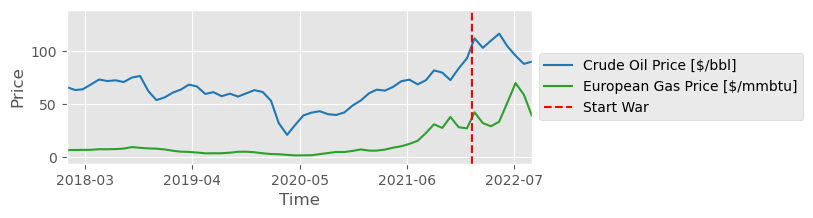

In [24]:
import matplotlib.dates as mdates

plt.rcParams["figure.figsize"] = (6,2)
ax = oil_data[['CRUDE_PETRO', 'NGAS_EUR', 'TIME_PERIOD']].set_index('TIME_PERIOD').plot(color = ['tab:blue', 'tab:green'])
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xlim([datetime.date(2018, 1, 1), datetime.date(2022, 10, 1)])
plt.axvline(dt.datetime(2022, 2, 20), color = 'red', label = 'Start War', linestyle = '--')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(['Crude Oil Price [$/bbl]', 'European Gas Price [$/mmbtu]', 'Start War'], loc='center left', bbox_to_anchor=(1, 0.5));

# Graphical Inspection Data

Calculation of means between periods to gain quick understanding:

In [25]:
pre_war_mean = trade_data_total[(trade_data_total['TIME_PERIOD']>=datetime.date(year = 2021, month = 4, day = 1))&
                 (trade_data_total['TIME_PERIOD'] < datetime.date(year = 2021, month = 8, day = 1))&
                 (trade_data_total['product']==product_filter)]['price'].mean()

post_war_mean = trade_data_total[(trade_data_total['TIME_PERIOD']>=datetime.date(year = 2022, month = 4, day = 1))&
                 (trade_data_total['TIME_PERIOD'] < datetime.date(year = 2022, month = 8, day = 1))&
                 (trade_data_total['product']==product_filter)]['price'].mean()

print('average pre-war:', pre_war_mean)
print()
print('post-war:', post_war_mean)

print('increase:', post_war_mean / pre_war_mean * 100)

average pre-war: 0.2574340610627369

post-war: 0.3733097112799996
increase: 145.01177883723153


In [26]:
print(spain_data_total['price'].tail(6).mean())
print(germany_data_total['price'].tail(6).mean())

0.31418011797210194
0.3231109154475889


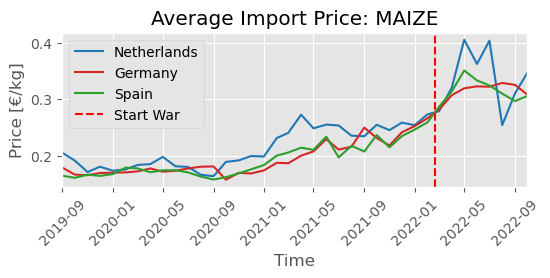

In [27]:
ax = trade_data_total[(trade_data_total['TIME_PERIOD']>=date_filter)&
                (trade_data_total['product']==product_filter)]\
[['TIME_PERIOD', 'price']]\
.set_index('TIME_PERIOD').plot(color = 'tab:blue')

germany_data_total[(germany_data_total['TIME_PERIOD']>=date_filter)&
                (germany_data_total['product']==product_filter)]\
[['TIME_PERIOD', 'price']]\
.set_index('TIME_PERIOD').plot(ax = ax, color = 'tab:red')

spain_data_total[(spain_data_total['TIME_PERIOD']>=date_filter)&
                 (spain_data_total['TIME_PERIOD']<=date_end)]\
[['TIME_PERIOD','price']].set_index('TIME_PERIOD').plot(ax = ax, color = 'tab:green')

plt.rcParams["figure.figsize"] = (20,3)
plt.xlim([datetime.date(2019, 9, 1), datetime.date(2022, 10, 1)])
ax.axvline(dt.datetime(2022, 2, 20), color = 'red', label = 'Invasion Russia', linestyle = '--')
ax.legend(["Netherlands","Germany","Spain", 'Start War'])

plt.xticks(rotation = 45)
plt.xlabel("Time")
plt.ylabel("Price [€/kg]");
plt.title("Average Import Price: "+ product_name);

## Plot for Price vs Oil / Natural Gas Price
Use: 
- NGAS_EUR for European Natural Gas Prices
- CRUDE_PETRO for Average Crude Oil Prices
- MAIZE
- WHEAT_US_HRW
- SUNFLOWER_OIL

In [28]:
# product_data_filt = trade_data_total[(trade_data_total['product'] == product_filter)]

# fig, ax1 = plt.subplots()
# training_span = ax1.axvspan(datetime.date(2021, 7, 1), datetime.date(2022, 7, 1), alpha=0.2, color='tab:blue', label = 'Training')
# validation_span = ax1.axvspan(datetime.date(2022, 7, 1), datetime.date(2022, 10, 1), alpha=0.2, color='tab:green', label = 'Validation')

# color = 'tab:red'
# ax1.set_xlabel('Time [Months]')
# ax1.set_ylabel('Key Driver Value')
# kd1 = ax1.plot(oil_data['TIME_PERIOD'], oil_data['CRUDE_PETRO'], color= color, label = 'Future Known')
# kd2 = ax1.plot(oil_data['TIME_PERIOD'][oil_data["TIME_PERIOD"] <= datetime.date(2022,7, 1)], oil_data['NGAS_EUR'][oil_data["TIME_PERIOD"] <= datetime.date(2022, 7, 1)], color= 'purple', label = 'Future Unkown')
# ax1.tick_params(axis='y', labelcolor=color)
# ax1.grid(False)
# # ax1.legend()
# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# color = 'tab:blue'
# ax2.set_ylabel('Target Price')  # we already handled the x-label with ax1
# price1 = ax2.plot(product_data_filt['TIME_PERIOD'][product_data_filt["TIME_PERIOD"] <= datetime.date(2022, 7, 1)], product_data_filt['price'][product_data_filt["TIME_PERIOD"] <= datetime.date(2022, 7, 1)], color=color, label = 'Target Price')
# price2 = ax2.plot(product_data_filt['TIME_PERIOD'][product_data_filt["TIME_PERIOD"] >= datetime.date(2022, 7, 1)], product_data_filt['price'][product_data_filt["TIME_PERIOD"] >= datetime.date(2022, 7, 1)], color=color, label = 'Target Price to Forecast', linestyle = '--')
# ax2.tick_params(axis='y')
# ax2.grid(False)
# # ax2.legend()

# plt.xlim([datetime.date(2021, 1, 1), datetime.date(2022, 10, 1)])

# fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.axvline(dt.datetime(2022, 2, 20), color = 'red')
# plt.axvline(dt.datetime(2022, 7, 1), color = 'green')
# # plt.axvline(dt.datetime(2022, 7, 22), color = 'green',linestyle = '--', label = 'Grain Initative Signed')
# # plt.axvline(dt.datetime(2020, 2, 27), color = 'blue', label = 'First Dutch COVID Infection')
# # plt.title('MAIZE vs EUR NATURAL GAS')
# plt.xlabel('Time [Months]')
# lns = kd1+kd2+price1+price2
# labs = [l.get_label() for l in lns]
# labs = ['Training', 'Validation'] + labs
# ax1.legend(labs, loc=0)
# ax2.legend(loc = 'lower right')
# ax1.set_yticks([])
# # plt.legend(loc = 'lower right')
# # plt.title(product_name + ' Situation')

# plt.show()

Add Ukrainian Trade Data for Direct Dependency 

In [31]:
trade_data_ukr = trade_data_pivot[(trade_data_pivot['PARTNER_Labels']=='Ukraine') & (trade_data_pivot["product"] == product_filter)]

trade_data_total_ukr = trade_data_ukr\
.groupby(['product', 'TIME_PERIOD']).agg({'OBS_VALUE_QUANTITY_TON': 'sum', 
                                          'OBS_VALUE_VALUE_1000EURO': 'sum'})

trade_data_total_ukr = trade_data_total_ukr.reset_index()
trade_data_total_ukr['price'] = trade_data_total_ukr['OBS_VALUE_VALUE_1000EURO']/trade_data_total_ukr['OBS_VALUE_QUANTITY_TON']

#### Graphs of specific Countries:

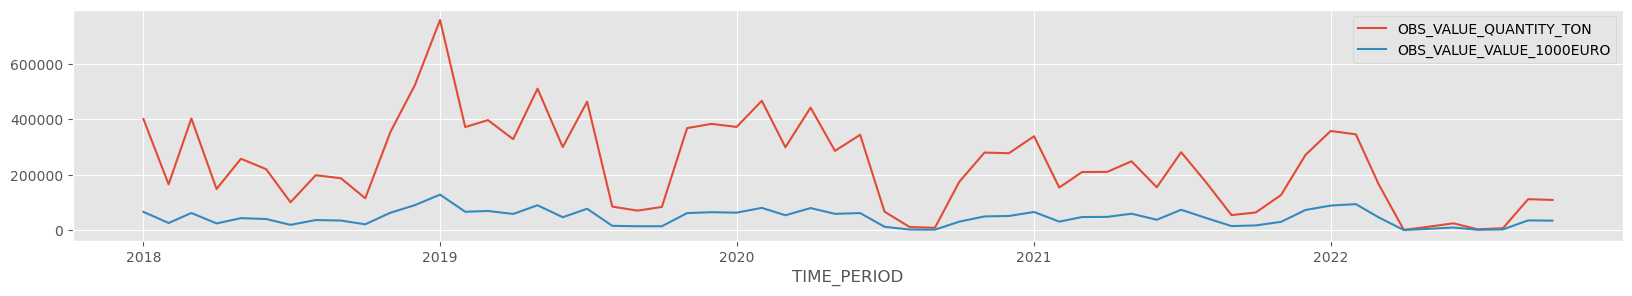

In [33]:
trade_data_pivot[(trade_data_pivot['PARTNER_Labels']=='Ukraine')&
                 (trade_data_pivot['TIME_PERIOD']>=date_filter)&
                (trade_data_pivot['product']==product_filter)]\
[['TIME_PERIOD', 'OBS_VALUE_QUANTITY_TON', 'OBS_VALUE_VALUE_1000EURO']]\
.set_index('TIME_PERIOD').plot();


## Supplier Composistion Shifts
Define a threshold (10% of total trade) for the supplier composition analysis

In [34]:
#  SO: 0.115
threshold = 0.115 * trade_data_total[(trade_data_total['TIME_PERIOD']>=date_filter) * (trade_data_total['product']==product_filter)]['OBS_VALUE_QUANTITY_TON'].max() 
print(threshold)

104720.6675


Collect data from relevant countries which surpassed the trade threshold and normalize data to sum up to 100%. This cell is used to visualize the supplier composition

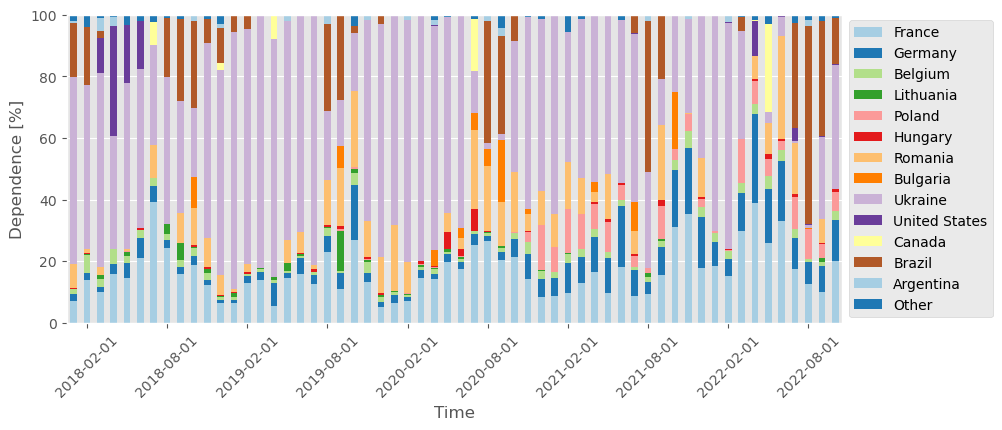

In [38]:
relevant_countries = pd.DataFrame()


time = trade_data_pivot['TIME_PERIOD']
rel_time = time[time >= date_filter].drop_duplicates()
relevant_countries["TIME_PERIOD"] = rel_time
relevant_countries.set_index('TIME_PERIOD', inplace=True, drop=True)

total_quant_df = trade_data_total[(trade_data_total['TIME_PERIOD']>=date_filter) * (trade_data_total['product']==product_filter)][['TIME_PERIOD', 'OBS_VALUE_QUANTITY_TON']]


for item in partner_countries["PARTNER_Labels"]:
    if float(trade_data_pivot[(trade_data_pivot['PARTNER_Labels']==item)&
                         (trade_data_pivot['TIME_PERIOD'] >= date_filter)&
                        (trade_data_pivot['product']==product_filter)]\
        [['OBS_VALUE_QUANTITY_TON']].sum()) > threshold:
        
        country_df = trade_data_pivot[(trade_data_pivot['PARTNER_Labels']== item)&
                         (trade_data_pivot['TIME_PERIOD']>=date_filter)&
                        (trade_data_pivot['product']==product_filter)]\
        [['TIME_PERIOD', 'OBS_VALUE_QUANTITY_TON']]
        
        
        country_df.set_index('TIME_PERIOD', inplace=True, drop=True)
        country_df.rename(columns = {"OBS_VALUE_QUANTITY_TON": item}, inplace = True)
        
        relevant_countries = relevant_countries.join(country_df, on = 'TIME_PERIOD')
         
plt.style.use('ggplot')

NUM_COLORS = len(relevant_countries.columns) + 1
clrs = sns.color_palette('Paired', n_colors=NUM_COLORS)  # a list of RGB tuples
colors = plt.cm.Spectral(np.linspace(0,1,11))
plt.rcParams["figure.figsize"] = (5,5)

sortedVal = relevant_countries.sort_values(by = 'TIME_PERIOD')
sortedVal = sortedVal.div(list(total_quant_df['OBS_VALUE_QUANTITY_TON']), axis = 0) * 100
sortedVal['Other'] = 100 - sortedVal[list(sortedVal.columns)].sum(axis=1)

sortedVal.plot.bar(stacked = True, figsize = (10,4), color = clrs)

plt.ylim(0, 100)
plt.xlabel('Time')
plt.ylabel('Dependence [%]')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(range(1, len(sortedVal), 6), rotation = 45)
plt.show()

## Plot for Relative dependence on Ukraine
Plot to visualize the dependence on Ukraine per country and per commodity type. Some manual modification required to account for the months without trade (added zeros).

In [40]:
# Generate new dataframe for ukraine dependence and set time period as index
ukraine_dependence = pd.DataFrame()
plt.rcParams["figure.figsize"] = (10,3)
plot_filter = datetime.date(year=2020, month=10, day=1)

time = trade_data['TIME_PERIOD']
rel_time = time[time >= date_filter].drop_duplicates()
ukraine_dependence["TIME_PERIOD"] = rel_time
ukraine_dependence.set_index('TIME_PERIOD', inplace=True, drop=True)

# Add different required columns and calculate dependence percentage-wise
ukraine_dependence = ukraine_dependence.merge(germany_data_total[(germany_data_total['TIME_PERIOD']>=plot_filter)&
                (germany_data_total['product']==product_filter)][['TIME_PERIOD', 'OBS_VALUE_QUANTITY_TON']], on = 'TIME_PERIOD')

ukraine_dependence = ukraine_dependence.rename(columns = {"OBS_VALUE_QUANTITY_TON" : "Total Import"})

ukraine_dependence = ukraine_dependence.merge(germany_data_pivot[(germany_data_pivot['PARTNER_Labels']=='Ukraine')&
                 (germany_data_pivot['TIME_PERIOD']>=plot_filter)&
                (germany_data_pivot['product']==product_filter)][['TIME_PERIOD', 'OBS_VALUE_QUANTITY_TON']], on = "TIME_PERIOD")

ukraine_dependence = ukraine_dependence.rename(columns = {"OBS_VALUE_QUANTITY_TON" : "Ukraine Import"})
ukraine_dependence["Ukraine Dependence Germany [%]"] = ukraine_dependence["Ukraine Import"] / ukraine_dependence["Total Import"] * 100
                                                        

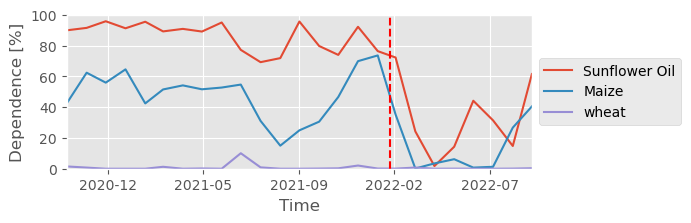

In [41]:
from matplotlib import ticker

# NL
dep_sunflower = [89.88088969687564, 91.45744301994303, 95.75264166188441, 91.1924205946106, 95.44524199111738, 89.16489771905137, 90.80445546377689, 89.06990000211114, 94.95415593852759, 77.17319422670495, 69.1943354781854, 71.81912352445521, 95.57810230904389, 79.69458140745836, 73.91356145994152, 92.16372181969994, 76.36113190120547, 72.21216975162157, 24.229428033187702, 1.732973146757733, 14.287260057564543, 44.138305524604725, 31.39394622625557, 14.761345665404708, 61.47465717737055]
dep_maize = [42.62121932469412, 62.349404100954885, 55.90136477976776, 64.52021370994319, 42.4143426008592, 51.47326082400596, 54.112085983034184, 51.57811306035273, 52.707405245424845, 54.636755783068416, 31.077340975513568, 14.972558912575904, 24.930864160871813, 30.54938030418473, 46.5650937287343, 69.84475481030088, 73.56872901825662, 35.18152895237646, 0.13539335365425356, 3.4553524914688833, 6.180653758122582, 0.7221061782514663, 1.2612790259646642, 26.68665652826796, 40.45330441657388]
dep_wheat = [1.4744631561610055, 0.7427859467441499, 0, 0, 0,  1.2544889855847352, 0, 0.16892318476955043, 0, 10.05380987554326, 0.8788459180277134, 0, 0, 0.10163238773415871, 0.25771987030305205, 2.0730741062496403, 0.11027620833956633, 0.08190367978341688, 0.756037748158837, 0, 0.05480399945291312, 0.03596235054613911,0, 0.08135822448882557, 0.3174474620400866]

# # SPAIN
# dep_sunflower = [30.413361392359135, 81.45325203252033, 77.57964532328938, 92.2774992147503, 58.765359537147575, 73.58851746103659, 79.68372166109418, 33.31151339013373, 63.87119526489536, 69.35730244675776, 87.72925370442728, 85.13927611584155, 77.22464688387377, 56.557954597624295, 73.54408587199335, 66.47496000755302, 79.87288099030646, 62.01451336821041, 0.28377198453286767, 0.17867864959615717, 20.681968494468496, 21.561150843835854, 18.61048750130861, 3.174221583854712, 45.53539973155986]
# dep_maize = [9.426168853010427, 33.35227923750023, 27.47116447343348, 50.31261847735651, 51.07544512375923, 36.765765360633544, 24.106801192942495, 16.36676457938361, 33.80839892172882, 4.80883982647701, 3.941112371959539, 4.35260604396115, 5.642437109966933, 37.71792694758254, 58.07354604419695, 71.93524762412717, 73.17693869052512, 15.154795004690857, 1.8700063415100578, 9.283974147321453, 19.765275387745618, 18.48372236504924, 8.91723733927488, 10.840445418138192, 26.158778869109195]
# dep_wheat = [20.481392902739703, 12.850060072758113, 4.423701466745983,0,0,0,0,0,0,0, 2.9483964174549646, 19.34045574032249, 3.211079691878363,0,0,0,0,0,0,0,0,0, 16.951598595771216, 18.258475038609934, 61.63674956006645]

# # GERMANY
# dep_sunflower = [0.0013018078857012676, 0.00041595261467813584, 0.00043826010737372633, 7.058611654530946, 7.780956212100895, 0.3941302548416627, 0.061776147728474354, 0.0, 0.7085397687922861, 0.24972650219309456, 0.09511308946337195, 0.00040935959784513113, 0.0003256840994508966, 0.003373974388467142, 0.23680228326246025, 0.0, 0.05934277872561383, 0.0002566530897182206, 0.24437972011263245, 3.2822350474400603, 1.3478431981398105, 1.0901941022433792, 0.49131711347507273, 0.2814834672555009, 0.8605152792955675]
# dep_maize = [17.748628388129642, 0.000201491591881803, 14.870219537434116,0, 12.278412066066554, 16.081057425527774, 0.0008259297904616122,0, 28.387825375742505, 1.4447248763095166, 1.0701200690392716, 0.9590627822806123, 0.0005668130933824571, 2.281307516838972, 1.4506494592378316, 0.9601682941759606, 0.07623109996309037, 3.296850843529818, 9.356680558841415, 9.818981160781448, 8.155182998752247, 12.900405557067982, 18.944480836668536, 37.69226317183022, 5.6605410185137455]
# dep_wheat = [0.2838166795188579, 0.1332439633243094, 0.16777188209514993, 0.24447732230722577, 0.3111440278862332, 0.07727359605672156, 0.124582417001957, 0.027054533622341562, 0.0003704323201629447, 0.16526877453091207, 0.0055637500361521205, 0.25159497877190523, 0.25293760462139364, 0.3414456133998308, 0.2755906173478562, 3.0027135522371573e-05, 0.043036441698011206, 0.035408752879019824, 0.15309436968599452, 1.9449180002322715, 0.7735713836289779, 2.4399518552826436, 1.5211097216810026]


import matplotlib.dates as mdates


df_dep = pd.DataFrame(list(zip(dep_sunflower, dep_maize, dep_wheat)),
               columns =['Sunflower Oil', 'Maize', 'Wheat'])

# plt.rcParams["figure.figsize"] = (20,3)
plt.rcParams["figure.figsize"] = (6,2)

time = trade_data['TIME_PERIOD']
rel_time = time[time >= plot_filter].drop_duplicates().tolist()
df_dep['TIME_PERIOD'] = rel_time
ax = df_dep.set_index('TIME_PERIOD').plot()
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.axvline(dt.datetime(2022, 2, 20), color = 'red', linestyle = '--')
plt.xlabel('Time')
plt.ylabel('Dependence [%]')
plt.ylim(0,100)
plt.legend(['Sunflower Oil', 'Maize', 'wheat'], loc='center left', bbox_to_anchor=(1, 0.5));
ax.set_xlim([datetime.date(2020, 10, 1), datetime.date(2022, 10, 1)]);
# plt.xticks(rotation = 45); # Rotates X-Axis Ticks by 45-degrees;


In [42]:
# # Generate new dataframe for ukraine dependence and set time period as index
# ukraine_dependence_ger = pd.DataFrame()

# time = trade_data['TIME_PERIOD']
# rel_time = time[time >= date_filter].drop_duplicates()
# ukraine_dependence_ger["TIME_PERIOD"] = rel_time
# # ukraine_dependence_ger.set_index('TIME_PERIOD', inplace=True, drop=True)
# # display(germany_data_total.head())

# # Add different required columns and calculate dependence percentage-wise
# ukraine_dependence_ger = ukraine_dependence_ger.merge(germany_data_total[(germany_data_total['TIME_PERIOD']>=date_filter)][['TIME_PERIOD', 'OBS_VALUE_QUANTITY_TON']], on = 'TIME_PERIOD')


# ukraine_dependence_ger = ukraine_dependence_ger.rename(columns = {"OBS_VALUE_QUANTITY_TON" : "Total Import"})


# ukraine_dependence_ger = ukraine_dependence_ger.merge(germany_data_pivot[(germany_data_pivot['PARTNER_Labels']=='Ukraine')&
#                  (germany_data_pivot['TIME_PERIOD']>=date_filter)][['TIME_PERIOD', 'OBS_VALUE_QUANTITY_TON']], on = "TIME_PERIOD")

# # display(ukraine_dependence_ger.head())

# ukraine_dependence_ger = ukraine_dependence_ger.rename(columns = {"OBS_VALUE_QUANTITY_TON" : "Ukraine Import"})

# ukraine_dependence_ger["Ukraine Dependence GER [%]"] = ukraine_dependence_ger["Ukraine Import"] / ukraine_dependence_ger["Total Import"] * 100

# # # Plot barplot
# ukraine_dependence_ger[(ukraine_dependence_ger['TIME_PERIOD']>=date_filter)][['TIME_PERIOD', "Ukraine Dependence GER [%]"]]\
#                     .set_index('TIME_PERIOD').plot.bar()
                                                                  
                                                                                                           
# plt.title('Dependence on Ukraine for ' + product_name +' - Germany')
                                                                     
                                                                     

Visualize total import quantity versus Ukraine share

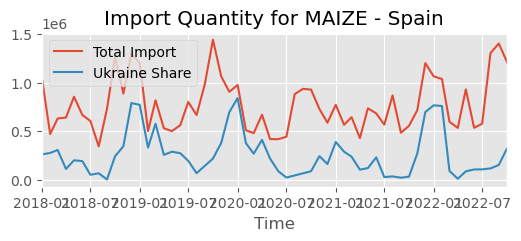

In [43]:
ax = spain_data_total[['TIME_PERIOD', 'OBS_VALUE_QUANTITY_TON']].set_index('TIME_PERIOD').plot()

spain_data_pivot[(spain_data_pivot['PARTNER_Labels']=='Ukraine')][['TIME_PERIOD', 'OBS_VALUE_QUANTITY_TON']].set_index('TIME_PERIOD').plot(ax = ax)
plt.legend(['Total Import', 'Ukraine Share'])
plt.title('Import Quantity for ' + product_name + ' - Spain');
plt.xlabel('Time')
# plt.ylim(0, 1.2e6)
plt.xlim([datetime.date(2018, 1, 1), datetime.date(2022, 10, 1)]);

Bar visualization of dependence on Ukraine

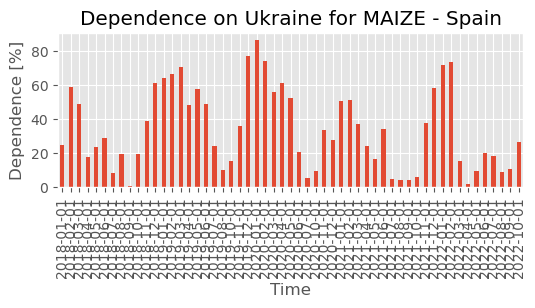

In [44]:
# Generate new dataframe for ukraine dependence and set time period as index
ukraine_dependence_sp = pd.DataFrame()

time = trade_data['TIME_PERIOD']
rel_time = time[time >= date_filter].drop_duplicates()
ukraine_dependence_sp["TIME_PERIOD"] = rel_time
# ukraine_dependence_sp.set_index('TIME_PERIOD', inplace=True, drop=True)


# Add different required columns and calculate dependence percentage-wise
ukraine_dependence_sp = ukraine_dependence_sp.merge(spain_data_total[(spain_data_total['TIME_PERIOD']>=date_filter)][['TIME_PERIOD', 'OBS_VALUE_QUANTITY_TON']], on = 'TIME_PERIOD')

ukraine_dependence_sp = ukraine_dependence_sp.rename(columns = {"OBS_VALUE_QUANTITY_TON" : "Total Import"})

ukraine_dependence_sp = ukraine_dependence_sp.merge(spain_data_pivot[(spain_data_pivot['PARTNER_Labels']=='Ukraine')&
                 (spain_data_pivot['TIME_PERIOD']>=date_filter)][['TIME_PERIOD', 'OBS_VALUE_QUANTITY_TON']], on = "TIME_PERIOD")

ukraine_dependence_sp = ukraine_dependence_sp.rename(columns = {"OBS_VALUE_QUANTITY_TON" : "Ukraine Import"})

ukraine_dependence_sp["Ukraine Dependence SPAIN [%]"] = ukraine_dependence_sp["Ukraine Import"] / ukraine_dependence_sp["Total Import"] * 100

# # Plot barplot
ukraine_dependence_sp[(ukraine_dependence_sp['TIME_PERIOD']>=date_filter)][['TIME_PERIOD', "Ukraine Dependence SPAIN [%]"]]\
                    .set_index('TIME_PERIOD').plot.bar(legend=None)


plt.xlabel('Time')
plt.ylabel('Dependence [%]')
plt.title('Dependence on Ukraine for ' + product_name + ' - Spain');
                                                                     
                                                                     

In [45]:
sunflower_oil_data = pd.read_csv("Data/sunflower_oil.csv")
wheat_data = pd.read_csv("Data/wheat.csv")                                       
maize_data = pd.read_csv("Data/maize_corn.csv")                                       

In [46]:
threshold = 0.115 * trade_data_total[(trade_data_total['TIME_PERIOD']>=date_filter) * (trade_data_total['product']==product_filter)]['OBS_VALUE_QUANTITY_TON'].max() 

In [47]:
relevant_countries_price = pd.DataFrame()
relevant_countries_quant = pd.DataFrame()

trade_data_pivot['price'] = trade_data_pivot['OBS_VALUE_VALUE_1000EURO'] / trade_data_pivot['OBS_VALUE_QUANTITY_TON']

time = trade_data_pivot['TIME_PERIOD']
rel_time = time[time >= date_filter].drop_duplicates()

relevant_countries_price["TIME_PERIOD"] = rel_time
relevant_countries_price.set_index('TIME_PERIOD', inplace=True, drop=True)

relevant_countries_quant["TIME_PERIOD"] = rel_time
relevant_countries_quant.set_index('TIME_PERIOD', inplace=True, drop=True)

total_quant_df = trade_data_total[(trade_data_total['TIME_PERIOD']>=date_filter) * (trade_data_total['product']==product_filter)][['TIME_PERIOD', 'OBS_VALUE_QUANTITY_TON']]


for item in partner_countries["PARTNER_Labels"]:
    if float(trade_data_pivot[(trade_data_pivot['PARTNER_Labels']==item)&
                         (trade_data_pivot['TIME_PERIOD'] >= date_filter)&
                        (trade_data_pivot['product']==product_filter)]\
        [['OBS_VALUE_QUANTITY_TON']].sum()) > threshold:
        
        country_df_price = trade_data_pivot[(trade_data_pivot['PARTNER_Labels']== item)&
                         (trade_data_pivot['TIME_PERIOD']>=date_filter)&
                        (trade_data_pivot['product']==product_filter)]\
        [['TIME_PERIOD', 'price']]
        
        country_df_quant = trade_data_pivot[(trade_data_pivot['PARTNER_Labels']== item)&
                         (trade_data_pivot['TIME_PERIOD']>=date_filter)&
                        (trade_data_pivot['product']==product_filter)]\
        [['TIME_PERIOD', 'OBS_VALUE_QUANTITY_TON']]
        
        
        country_df_price.set_index('TIME_PERIOD', inplace=True, drop=True)
        country_df_quant.set_index('TIME_PERIOD', inplace=True, drop=True)

        country_df_price.rename(columns = {"price": item}, inplace = True)
        country_df_quant.rename(columns = {"OBS_VALUE_QUANTITY_TON": item}, inplace = True)

        
        relevant_countries_price = relevant_countries_price.join(country_df_price, on = 'TIME_PERIOD')
        relevant_countries_quant = relevant_countries_quant.join(country_df_quant, on = 'TIME_PERIOD')

plt.style.use('ggplot')


NUM_COLORS = len(relevant_countries.columns)
clrs = sns.color_palette('Paired', n_colors=NUM_COLORS)  # a list of RGB tuples
colors = plt.cm.Spectral(np.linspace(0,1,30))
plt.rcParams["figure.figsize"] = (5,5)

sortedVal_price = relevant_countries_price.sort_values(by = 'TIME_PERIOD')
sortedVal_price.replace([np.inf, -np.inf], np.nan, inplace=True)

sortedVal_quant = relevant_countries_quant.sort_values(by = 'TIME_PERIOD')
sortedVal_quant.replace([np.inf, -np.inf], np.nan, inplace=True)

## Price Shift Analysis
Analysis to visualize the shifts in price action and import share per country before and after the start of the war

In [61]:
pre_start = datetime.date(year = 2020, month = 3, day = 1)
pre_end = datetime.date(year = 2022, month = 3, day = 1)

post_start = datetime.date(year = 2022, month = 5, day = 1)
post_end = datetime.date(year = 2022, month = 5, day = 1)


country_names = list(sortedVal_quant.columns.values)

pre_war_share_average = list(sortedVal[(sortedVal.index >= pre_start) & (sortedVal.index <= pre_end)].mean())
post_war_share_average = list(sortedVal[(sortedVal.index >= post_start) & (sortedVal.index <= post_end)].mean())

pre_war_quantities_average = list(sortedVal_quant[(sortedVal_quant.index >= pre_start) & (sortedVal_quant.index <= pre_end)].mean())
post_war_quantities_average = list(sortedVal_quant[(sortedVal_quant.index >= post_start) & (sortedVal_quant.index <= post_end)].mean())

pre_war_prices_average = list(sortedVal_price[(sortedVal_price.index >= pre_start) & (sortedVal_price.index <= pre_end)].mean())
post_war_prices_average = list(sortedVal_price[(sortedVal_price.index >= post_start) & (sortedVal_price.index <= post_end)].mean())

price_change_df = pd.DataFrame(list(zip(pre_war_quantities_average, post_war_quantities_average, pre_war_prices_average, post_war_prices_average, pre_war_share_average, post_war_share_average))
                            ,columns = ['pre_war_quant', 'post_war_quant', 'pre_war_price', 'post_war_price', 'pre_war_share', 'post_war_share'],
                             index = country_names)

price_change_df['delta_price'] = price_change_df['post_war_price'] - price_change_df['pre_war_price']
price_change_df['delta_share'] = price_change_df['post_war_share'] - price_change_df['pre_war_share']

price_change_df['pre_priceShare'] = price_change_df['pre_war_share'] / 100 * price_change_df['pre_war_price']
price_change_df['post_priceShare'] = price_change_df['post_war_share'] / 100 * price_change_df['post_war_price']

In [66]:
print(price_change_df['pre_priceShare'].sum())
print(price_change_df['post_priceShare'].sum())

1333.554180979268
1358.1481


In [67]:
pre_war_avg = trade_data_total[(trade_data_total["TIME_PERIOD"] >= pre_start) & (trade_data_total["TIME_PERIOD"] <= pre_end)]["price"].mean()
post_war_avg = trade_data_total[(trade_data_total["TIME_PERIOD"] >= post_start) & (trade_data_total["TIME_PERIOD"] <= post_end)]["price"].mean()

Plotter to visualize the price effects of the war

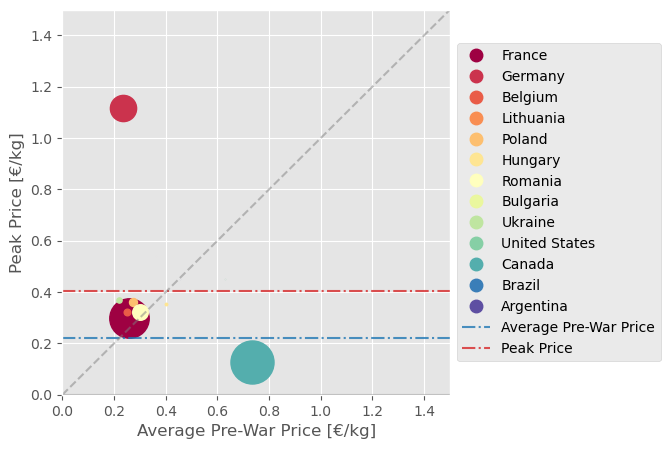

In [78]:
fig, ax = plt.subplots()
plt.axhline(0, color = 'grey', alpha = 0.5)
plt.axvline(0, color = 'grey', alpha = 0.5)

count = 0

colors = plt.cm.Spectral(np.linspace(0,1,len(price_change_df)))

for i, r in price_change_df.iterrows():
    ax.plot(r['pre_war_price'], r['post_war_price'], 'o', color = colors[count], label = i, markersize = r["post_war_share"] / 10 ** 3.5)
    count+=1
    
# plt.title('Price and Share Shifts ' + product_name)
plt.xlabel('Average Pre-War Price [€/kg]')
plt.ylabel('Peak Price [€/kg]')

# plt.axhline(post_war_avg)
plt.axhline(pre_war_avg, color = 'tab:blue', label = 'Average Pre-War Price', alpha = 0.8, linestyle = 'dashdot')
plt.axhline(post_war_avg, color = 'tab:red', label = 'Peak Price', alpha = 0.8, linestyle = 'dashdot')

lgnd = plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), scatterpoints = 1);

for legend_handle in lgnd.legendHandles:
    legend_handle.set_markersize(9)
    
plt.ylim(0, 1.5)
plt.xlim(0, 1.5)

# ax.set_aspect('equal', adjustable='box')
ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle = '--', alpha = 0.5, color = 'grey');


# Substitute Product Analysis
Additional analysis on whether there were notable shifts to subtitute products. Conclusion is that no notable shifts (in absolute sense) were observed for any of the target commodities
## Sunflower Oil

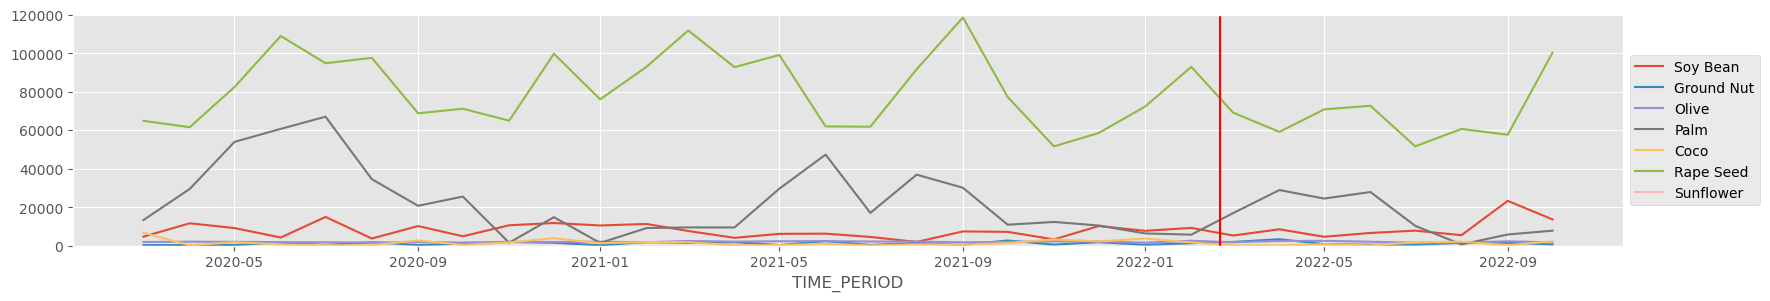

In [79]:
sunflower_oil_sub = pd.read_csv("Data/sunflower_oil_subtitutes.csv")

sunflower_oil_sub["TIME_PERIOD"] = pd.to_datetime(sunflower_oil_sub["TIME_PERIOD"], format = '%Y-%m').dt.date
sunflower_oil_sub = sunflower_oil_sub.rename(columns={"partner": "PARTNER_codes", "declarant": "DECLARANT_codes"})
sunflower_oil_sub = pd.merge(sunflower_oil_sub, partner_countries, on = ['PARTNER_codes'], how = 'inner')


sunflower_oil_sub_pivot = sunflower_oil_sub.pivot(index=['PARTNER_Labels', 'TIME_PERIOD', 'product'], 
                              columns='indicators', 
                              values=['OBS_VALUE'])

sunflower_oil_sub_pivot.columns = sunflower_oil_sub_pivot.columns.map('_'.join)
sunflower_oil_sub_pivot = sunflower_oil_sub_pivot.reset_index()
sunflower_oil_sub_pivot = sunflower_oil_sub_pivot.dropna()

sunflower_oil_total = sunflower_oil_sub_pivot\
.groupby(['product', 'TIME_PERIOD']).agg({'OBS_VALUE_QUANTITY_TON': 'sum', 
                                          'OBS_VALUE_VALUE_1000EURO': 'sum'})

sunflower_oil_total = sunflower_oil_total.reset_index()
sunflower_oil_total['price'] = sunflower_oil_total['OBS_VALUE_VALUE_1000EURO']/sunflower_oil_total['OBS_VALUE_QUANTITY_TON']

sunflower_oil_total = sunflower_oil_total[sunflower_oil_total["TIME_PERIOD"] <= date_end]

soya_bean_oil = sunflower_oil_total[sunflower_oil_total["product"] == 1507]
ground_nut_oil = sunflower_oil_total[sunflower_oil_total["product"] == 1508]
olive_oil = sunflower_oil_total[sunflower_oil_total["product"] == 1509]
palm_oil = sunflower_oil_total[sunflower_oil_total["product"] == 151110]
coco_oil = sunflower_oil_total[sunflower_oil_total["product"] == 151311]
rape_oil = sunflower_oil_total[sunflower_oil_total["product"] == 1514]

plt.rcParams["figure.figsize"] = (20,3)

ax = soya_bean_oil[['TIME_PERIOD','OBS_VALUE_QUANTITY_TON']].set_index('TIME_PERIOD').plot()
ground_nut_oil[['TIME_PERIOD','OBS_VALUE_QUANTITY_TON']].set_index('TIME_PERIOD').plot(ax = ax);
olive_oil[['TIME_PERIOD','OBS_VALUE_QUANTITY_TON']].set_index('TIME_PERIOD').plot(ax = ax);
palm_oil[['TIME_PERIOD','OBS_VALUE_QUANTITY_TON']].set_index('TIME_PERIOD').plot(ax = ax);
coco_oil[['TIME_PERIOD','OBS_VALUE_QUANTITY_TON']].set_index('TIME_PERIOD').plot(ax = ax);
rape_oil[['TIME_PERIOD','OBS_VALUE_QUANTITY_TON']].set_index('TIME_PERIOD').plot(ax = ax);
trade_data_total[trade_data_total["TIME_PERIOD"] >= pre_start][['TIME_PERIOD','OBS_VALUE_QUANTITY_TON']].set_index('TIME_PERIOD').plot(ax = ax);




plt.axvline(dt.datetime(2022, 2, 20), color = 'red')
plt.ylim(0, 120000)
lgnd = plt.legend(['Soy Bean', 'Ground Nut', 'Olive', 'Palm', 'Coco', 'Rape Seed', 'Sunflower'], loc='center left', bbox_to_anchor=(1.0, 0.5), scatterpoints = 1);


## Maize

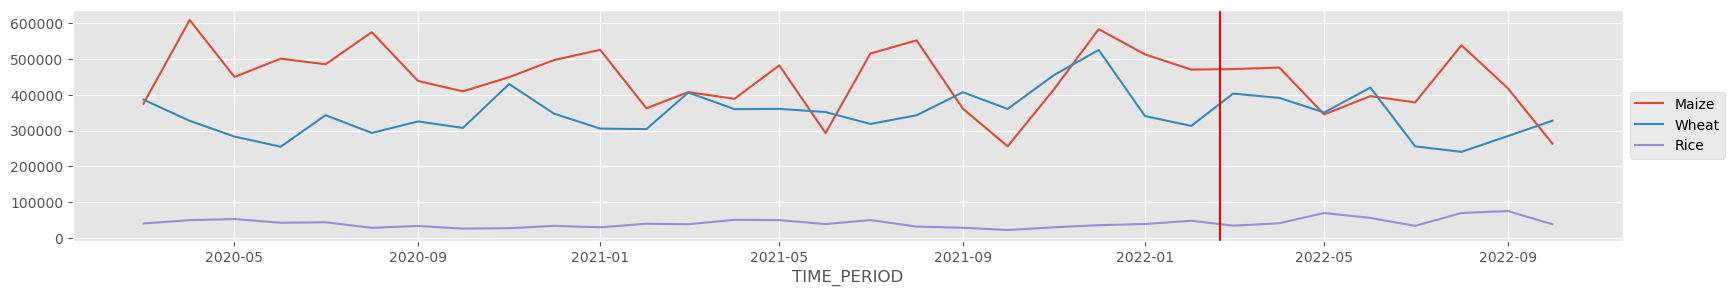

In [80]:
maize_sub = pd.read_csv("Data/maize_substitutes.csv")

maize_sub["TIME_PERIOD"] = pd.to_datetime(maize_sub["TIME_PERIOD"], format = '%Y-%m').dt.date
maize_sub = maize_sub.rename(columns={"partner": "PARTNER_codes", "declarant": "DECLARANT_codes"})
maize_sub = pd.merge(maize_sub, partner_countries, on = ['PARTNER_codes'], how = 'inner')


maize_sub_pivot = maize_sub.pivot(index=['PARTNER_Labels', 'TIME_PERIOD', 'product'], 
                              columns='indicators', 
                              values=['OBS_VALUE'])

maize_sub_pivot.columns = maize_sub_pivot.columns.map('_'.join)
maize_sub_pivot = maize_sub_pivot.reset_index()
maize_sub_pivot = maize_sub_pivot.dropna()

maize_sub_total = maize_sub_pivot\
.groupby(['product', 'TIME_PERIOD']).agg({'OBS_VALUE_QUANTITY_TON': 'sum', 
                                          'OBS_VALUE_VALUE_1000EURO': 'sum'})

maize_sub_total = maize_sub_total.reset_index()
maize_sub_total['price'] = maize_sub_total['OBS_VALUE_VALUE_1000EURO']/maize_sub_total['OBS_VALUE_QUANTITY_TON']

maize_sub_total = maize_sub_total[maize_sub_total["TIME_PERIOD"] <= date_end]

maize = maize_sub_total[maize_sub_total["product"] == 10059000]
wheat = maize_sub_total[maize_sub_total["product"] == 100199]
rice = maize_sub_total[maize_sub_total["product"] == 1006]

ax = maize[['TIME_PERIOD','OBS_VALUE_QUANTITY_TON']].set_index('TIME_PERIOD').plot()
wheat[['TIME_PERIOD','OBS_VALUE_QUANTITY_TON']].set_index('TIME_PERIOD').plot(ax = ax);
rice[['TIME_PERIOD','OBS_VALUE_QUANTITY_TON']].set_index('TIME_PERIOD').plot(ax = ax);


plt.axvline(dt.datetime(2022, 2, 20), color = 'red')
# plt.ylim(0, 120000)
lgnd = plt.legend(['Maize', 'Wheat', 'Rice'], loc='center left', bbox_to_anchor=(1.0, 0.5), scatterpoints = 1);


Plot was included in report, data based on 

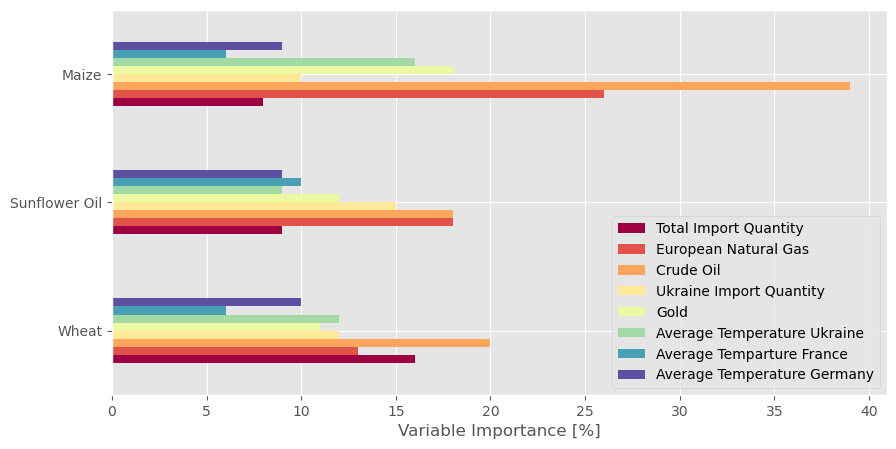

In [81]:
f2 = pd.DataFrame(np.array([[0.16,0.13,0.20,0.12,0.11,0.12,0.06,0.10], [0.09,0.18,0.18,0.15,0.12,0.09,0.10,0.09], [0.08,0.26,0.39,0.10,0.18,0.16,0.06,0.09]]), 
                  columns=["Total Import Quantity","European Natural Gas","Crude Oil","Ukraine Import Quantity","Gold","Average Temperature Ukraine","Average Temparture France","Average Temperature Germany"], index = ['Wheat', 'Sunflower Oil', 'Maize'])

f2 = f2 * 100

plt.rcParams["figure.figsize"] = (10,5)
colorsbarh = plt.cm.Spectral(np.linspace(0,1,8))
f2.plot.barh(color = colorsbarh)
plt.xlabel('Variable Importance [%]');